# Numerical simulation of short-circuit at the terminals of a synchronous generator in Phasor mode

This notebook is a companion to the course [Control and Operation of Electric Power Systems](https://sps.cut.ac.cy/courses/een452/).

In [1]:
function [A] = matA() 

global Re Le Ldd Ldf Lff Lqq Lqq1 Lq1q1 Ra Rf Rq1 theta0 ;

A=zeros(14,14) ;

A(1,3)=-Rf ;          % d psif/dt
A(2,4)=-Rq1;          % d psiq1/dt
A(3,7)=1 ;            % net equ. x comp
A(3,11)=-Re ;
A(3,12)=Le ;
A(4,8)=1 ;            % net equ. y comp
A(4,12)=-Re ;
A(4,11)=-Le ;
A(5,5)=1 ;            % vd(vx,vy)
A(5,7)=-cos(theta0) ;
A(5,8)=-sin(theta0) ;
A(6,6)=1 ;            % vq(vx,vy)
A(6,7)=-sin(theta0) ;
A(6,8)=cos(theta0) ;
A(7,9)=1 ;            % id(vx,vy)
A(7,11)=-cos(theta0) ;
A(7,12)=-sin(theta0) ;
A(8,10)=1 ;           % iq(vx,vy)
A(8,11)=-sin(theta0) ;
A(8,12)=cos(theta0) ;
A(9,5)=1 ;            % Park - d axis
A(9,9)=Ra ;
A(9,14)=1 ;
A(10,6)=1 ;           % Park - q axis
A(10,10)=Ra ;
A(10,13)=-1 ;
A(11,13)=1 ;          % psid(id,if)
A(11,9)=-Ldd ; 
A(11,3)=-Ldf ;
A(12,14)=1 ;          % psiq(iq)
A(12,10)=-Lqq ;
A(12,4)=-Lqq1 ;
A(13,1)=1 ;           % psif(id,idf)
A(13,3)=-Lff ;
A(13,9)=-Ldf ;
A(14,2)=1 ;           % psiq1(iq,iq1)
A(14,4)=-Lq1q1 ;
A(14,10)=-Lqq1 ;

endfunction

In [2]:
global Re Le Ldd Ldf Lff Lqq Lqq1 Lq1q1 Ra Rf Rq1 theta0 ;

j=sqrt(-1) ;

% --------------- DATA ---------------
% network and operating point
% P and Q are in per unit on a three-phase base power (single-phase model)

Xe=0.20 ;
Re=0.01 ;
P=0.5 ;
Q=0.1 ;
V=1 ;

% machine parameters

Ra=0.005 ;
Xd=2.4 ;
Xq=2.4 ;
Xl=0.2 ;
Xpd=0.40 ;
Xpq=0.25 ;
fN=50. ;
Tpdo_s=7. ;
Tpqo_s=0.3 ;

% time step size, event times and simulation interval

h= 0.01 ;
T1=0.05 ;             % short-circuit is applied
T2=0.20 ;             % short-circuit is cleared
Tsim=0.40 ;

% -------------- END OF DATA --------------

% derived parameters

wN=2*pi*fN ;
TB=1/(2*pi*fN) ;
Le=Xe ;
Ldd=Xd ;
Ldf=Xd-Xl ;
Lff=Ldf^2/(Xd-Xpd) ;
Tpdo=Tpdo_s/TB ;
Rf=Lff/Tpdo ;
Lqq=Xq ;
Lqq1=Xq-Xl ;
Lq1q1=Lqq1^2/(Xq-Xpq) ;
Tpqo=Tpqo_s/TB ;
Rq1=Lq1q1/Tpqo ;

% initialization of state variables

vx=V ;                                % network voltages and currents
vy=0 ;
phasI=(P-j*Q)/V ;
ix=real(phasI) ;
iy=imag(phasI) ;
phasE=V-(Re+j*Xe)*phasI ;
ex=real(phasE) ;
ey=imag(phasE) ;

phi=angle(V+Ra*phasI+j*Xq*phasI);     % machine
theta0=phi+pi/2 ;
vd=V*cos(theta0) ;
vq=V*sin(theta0) ;
id=abs(phasI)*cos(theta0-angle(phasI)) ;
iq=abs(phasI)*sin(theta0-angle(phasI)) ;
psid=vq+Ra*iq ;
psiq=Lqq*iq ;
ifd=(psid-Ldd*id)/Ldf ;
psif=Lff*ifd+Ldf*id ;
Vf=Rf*ifd ;
iq1=0. ;
psiq1=Lqq1*iq ;

% identify differential and algebraic states

dif= [1 2] ;
alg= [3 4 5 6 7 8 9 10 11 12 13 14] ;

% allocate space to store trajectory

nbsteps=ceil(Tsim/h)+2 ;
time=zeros(1,nbsteps) ;
xhist=zeros(14,nbsteps) ;

% initialisation of integration

t=0 ;
time(1)=t ;

%    1    2     3   4   5  6  7 8  9  10 11 12  13   14
x=[ psif psiq1 ifd iq1 vd vq vx vy id iq ix iy psid psiq ]' ;
xhist(1:14,1)=x ;

A= matA() ;
u= [ Vf 0 -ex -ey 0 0 0 0 0 0 0 0 0 0 ]' ;

% integration method

k= 1 ;
hvar= h ;
while t<= Tsim
    c = A*x + u ;

    t= t+hvar ;
    k=k+1 ;
    time(k)=t ;
    
    M= A ;
    M(dif,dif)= M(dif,dif) - (2/hvar/wN)*eye(size(dif,2)) ;   
    b= -u ;
    b(dif)= b(dif) - (2/hvar/wN)*x(dif) - c(dif) ;
    x= M\b ;
    xhist(1:14,k)=x ;

    if t >= T1 && t-h < T1
        u= [ Vf  0  0  0  0  0  0  0  0  0  0  0  0  0]' ;        
        hvar=0.001 ;
    elseif t >= T1+0.001 && t-h < T1+0.001
        hvar=h ;
    elseif t>= T2 && t-h < T2
        u= [ Vf  0 -ex -ey  0  0  0  0  0  0  0  0  0  0]' ; 
        hvar=0.001 ;
    elseif t >= T2+0.001 && t-h < T2+0.001
        hvar=h ;
    end
end
nbsteps=k ;

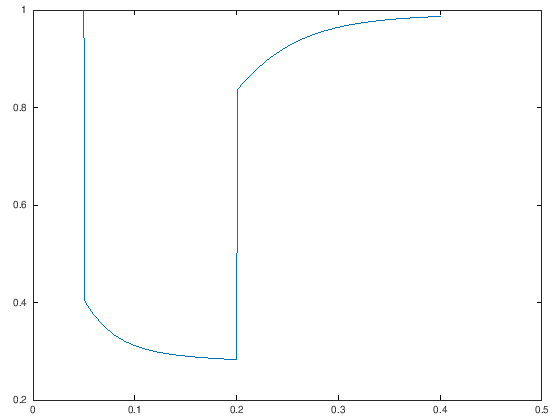

In [3]:
plot(time, sqrt(xhist(7,:).^2+xhist(8,:).^2))